In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot
import seaborn as sbn
import seaborn as sbn
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [2]:
pd. set_option("display.max_columns", None) 

In [3]:
df = pd.read_csv('./android-fitness-and-medical-cleaned-data(no-duplicate).csv')

#### FEATURE ENGINNERING

**Rating Count Categorization**

1+, 5+, 10+, 50+, 100+, 500+, 1,000+, 5,000+, 10,000+, 50,000+, 100,000+, 500,000+, 1,000,000+, 5,000,000, 10,000,000+, 50,000,000+

In [4]:
def determine_if_app_is_free_or_not(price):
    if (price > 0):
        return 'PAID'
    return 'FREE'

In [5]:
def grade_app_with_rating(app_rating):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        return 'VERY GOOD'
    if (app_rating >=4.5):
        return 'EXCELLENT'

In [6]:
def grade_app_with_rating2(app_rating, rating_count):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        if rating_count < 50:
            return 'FAIR'
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD' 
        else:
            return 'VERY GOOD'
    if (app_rating >=4.5):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD'
        elif rating_count >=100 and rating_count < 500:
            return 'VERY GOOD'
        else:
            return 'EXCELLENT'

In [7]:
def create_rating_count_range(rating_count):
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    if (rating_count >=1000 and rating_count<5000):
        return '1,000+'
    if (rating_count >=5000 and rating_count<10000):
        return '5,000+'
    if (rating_count >=10000 and rating_count<50000):
        return '10,000+'
    if (rating_count >=50000 and rating_count<100000):
        return '50,000+'
    if (rating_count >=100000 and rating_count<500000):
        return '100,000+'
    if (rating_count >=500000 and rating_count<1000000):
        return '500,000+'
    if (rating_count >=1000000 and rating_count<5000000):
        return '1,000,000+'
    if (rating_count >=5000000 and rating_count<10000000):
        return '5,000,000+'
    if (rating_count >=10000000 and rating_count<50000000):
        return '10,000,000+'
    if (rating_count >=50000000 and rating_count<100000000):
        return '50,000,000+'
    return 0

In [8]:
def is_app_updated_in_2022(last_updated_date, released_date, version):
    if (version == '1.0.0'):
        return False
    if (last_updated_date == released_date):
        return False
    if '2022' in last_updated_date:
        return True
    return False

In [9]:
def is_app_ever_updated(last_updated_date, released_date, version):
    if (version == '1.0.0'):
        return False
    if (last_updated_date == released_date):
        return False
    return True

In [10]:
def is_app_version_device_dependent(version):
    return version == 'Varies with device'

In [11]:
def is_app_available_in_multiple_countries(count):
    return count > 1

In [12]:
def create_price_category(price):
    if (price >0.0 and price<1.0):
        return '0+'
    if (price >=1 and price<5):
        return '1+'
    if (price >=5 and price<10):
        return '5+'
    if (price >=10 and price<50):
        return '10+'
    if (price >=50 and price<100):
        return '50+'
    if (price >=100 and price<500):
        return '100+'
    if (price >=500 and price<1000):
        return '500+'
    return 0

In [13]:
def perform_feature_engineering(df):
    df['Service Type'] = df['Price'].apply(determine_if_app_is_free_or_not)
    df['is_available_in_multiple_countries'] = df['Country Count'].apply(is_app_available_in_multiple_countries)
    df['is_version_app_dependent'] = df['Version'].apply(is_app_version_device_dependent)
    df['Rating Count Range'] = df['Rating Count'].apply(create_rating_count_range)
    df['Price Category'] = df['Price'].apply(create_price_category)
#     df['App Grade'] = df['Average Rating'].apply(grade_app_with_rating)
    for index in df.index:
        link = df.at[index, 'App Link']
        last_updated_date = df.at[index, 'Last Updated']
        released_date = df.at[index, 'Released Date']
        version = df.at[index, 'Version']
        rating_count = df.at[index, 'Rating Count']
        average_rating = df.at[index, 'Average Rating']
        df.at[index, 'is_updated_this_year'] = is_app_updated_in_2022(last_updated_date, released_date, version)
        df.at[index, 'is_app_ever_updated'] = is_app_ever_updated(last_updated_date, released_date, version)
        df.at[index, 'App Grade'] = grade_app_with_rating2(average_rating, rating_count)

In [14]:
perform_feature_engineering(df)

In [15]:
df[df['Average Rating'] > 4].sort_values(by='Rating Count', ascending=True)

,Unnamed: 0,App Name,Age Rating,Price,InApp Purchase,Average Rating,Rating Count,App Link,Last Updated,Released Date,Downloads,Version,Application Type,Country Count,Countries,Service Type,is_available_in_multiple_countries,is_version_app_dependent,Rating Count Range,Price Category,is_updated_this_year,is_app_ever_updated,App Grade
707,4979,SJA First Aid Fast,PEGI 3,0.00,False,5.0,7,https://play.google.com/store/apps/details?id=...,"May 6, 2022","Mar 28, 2022","5,000+",1.0.3,MEDICAL,1,GB,FREE,False,False,5+,0,True,True,FAIR
711,4989,OrthoFlow,PEGI 3,4.99,False,4.6,12,https://play.google.com/store/apps/details?id=...,"Jul 15, 2018","Jul 15, 2018","1,000+",1.0.0,MEDICAL,1,GB,PAID,False,False,10+,1+,False,False,FAIR
677,4914,CFR PLUS,PEGI 3,0.00,True,4.4,15,https://play.google.com/store/apps/details?id=...,"Jul 26, 2021","Jun 22, 2020","1,000+",1.0.7,MEDICAL,1,GB,FREE,False,False,10+,0,False,True,FAIR
678,4915,Foundation Doctor Handbook,PEGI 3,2.99,False,4.8,17,https://play.google.com/store/apps/details?id=...,"Aug 4, 2021","Jul 19, 2019","1,000+",18.0,MEDICAL,1,GB,PAID,False,False,10+,1+,False,True,FAIR
449,1616,Clarity Locums,PEGI 3,0.00,False,4.4,35,https://play.google.com/store/apps/details?id=...,"Jun 14, 2022","Nov 24, 2019","10,000+",7.41,MEDICAL,1,IE,FREE,False,False,10+,0,True,True,FAIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,6084,Six Pack in 30 Days,PEGI 3,0.00,True,4.9,2130000,https://play.google.com/store/apps/details?id=...,"Jun 19, 2022","Jan 9, 2018","100,000,000+",1.1.1,FITNESS,50,"SE,FR,GB,GF,GP,DK,GR,PL,RE,PM,NL,AT,MC,MT,NO,B...",FREE,True,False,"1,000,000+",0,True,True,EXCELLENT
916,6063,MyFitnessPal - Calorie Counter,PEGI 3,0.00,True,4.4,2510000,https://play.google.com/store/apps/details?id=...,"Jun 22, 2022","Apr 26, 2010","100,000,000+",Varies with device,FITNESS,45,"SE,FR,GB,GF,GP,DK,GR,PL,RE,PM,NL,AT,MT,NO,BL,L...",FREE,True,True,"1,000,000+",0,True,True,VERY GOOD
953,6100,Flo Menstrual & Period Tracker,PEGI 3,0.00,True,4.7,2630000,https://play.google.com/store/apps/details?id=...,"Jun 22, 2022","Apr 12, 2016","50,000,000+",Varies with device,FITNESS,50,"SE,FR,GB,GF,GP,DK,GR,PL,RE,PM,NL,AT,MC,MT,NO,B...",FREE,True,True,"1,000,000+",0,True,True,EXCELLENT
944,6091,Home Workout - No Equipment,PEGI 3,0.00,True,4.9,2840000,https://play.google.com/store/apps/details?id=...,"Apr 27, 2022","Nov 8, 2017","100,000,000+",1.1.8,FITNESS,50,"SE,FR,GB,GF,GP,DK,GR,PL,RE,PM,NL,AT,MC,MT,NO,B...",FREE,True,False,"1,000,000+",0,True,True,EXCELLENT


#### VISUALIZATION

In [16]:
df[:5]

,Unnamed: 0,App Name,Age Rating,Price,InApp Purchase,Average Rating,Rating Count,App Link,Last Updated,Released Date,Downloads,Version,Application Type,Country Count,Countries,Service Type,is_available_in_multiple_countries,is_version_app_dependent,Rating Count Range,Price Category,is_updated_this_year,is_app_ever_updated,App Grade
0,0,TraceTogether,PEGI 3,0.00,False,2.9,57100,https://play.google.com/store/apps/details?id=...,"May 31, 2022","Mar 9, 2020","1,000,000+",2.14.2,MEDICAL,31,"FO,HR,SM,GI,EE,SI,GL,SK,PF,SJ,IS,VA,BG,WF,LI,A...",FREE,True,False,"50,000+",0,True,True,FAIR
1,1,Blood Pressure Analyze,PEGI 3,0.00,True,3.9,12300,https://play.google.com/store/apps/details?id=...,"Sep 9, 2021","Apr 1, 2019","1,000,000+",1.3.2,MEDICAL,32,"FO,HR,SM,GI,EE,SI,GL,SK,PF,SJ,IS,VA,BG,WF,LI,A...",FREE,True,False,"10,000+",0,False,True,GOOD
2,2,Monash University FODMAP diet,PEGI 3,5.60,False,3.5,2470,https://play.google.com/store/apps/details?id=...,"Jan 18, 2022","Nov 6, 2013","100,000+",3.0.9,MEDICAL,46,"FO,PT,HR,IT,DE,FI,EE,HU,SI,ES,GL,IE,RO,SK,PF,S...",PAID,True,False,"1,000+",5+,True,True,GOOD
3,3,Squeezy: NHS Pelvic Floor App,PEGI 3,2.99,False,4.6,3250,https://play.google.com/store/apps/details?id=...,"Mar 4, 2019","Sep 17, 2014","50,000+",Varies with device,MEDICAL,45,"FO,PT,HR,SM,GI,FI,EE,HU,SI,GL,IE,RO,SK,PF,SJ,I...",PAID,True,True,"1,000+",1+,False,True,EXCELLENT
4,4,Muscle Trigger Point Anatomy,PEGI 3,2.69,False,4.5,1590,https://play.google.com/store/apps/details?id=...,"Jul 30, 2019","Jan 27, 2011","50,000+",2.4.8,MEDICAL,42,"FO,PT,HR,IT,DE,FI,EE,HU,SI,GL,IE,RO,SK,PF,SJ,I...",PAID,True,False,"1,000+",1+,False,True,EXCELLENT


In [17]:
def draw_histogram(data, x_axis_title, height=5, aspect=1.6):
    sbn.displot(data, color = 'darkblue', kind='hist', height=5, aspect=1.6)
    pyplot.xlabel(x_axis_title)
    pyplot.ylabel('Density')

def draw_count_plot(data, x_column, x_label, y_label, fig_size=(8,6), order=None, hue=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue )
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.show()

def set_plot_labels(x_label, y_label, font_size):
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=font_size)

In [18]:
rating_count_range_order = ['0', '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', '5,000+', '10,000+', '50,000+', 
                            '100,000+', '500,000+', '1,000,000+', '5,000,000+']
price_range_order = [0, '0+', '1+', '5+', '10+', '50+', '100+', '500+']
app_grade_order = ['BAD', 'FAIR', 'GOOD', 'VERY GOOD', 'EXCELLENT']

#### Price influence

In [19]:
df['Price'].max(), df['Price'].min()

(109.99, 0.0)

In [20]:
df['Price Category'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
1566    False
1567    False
1568    False
1569    False
1570    False
Name: Price Category, Length: 1571, dtype: bool

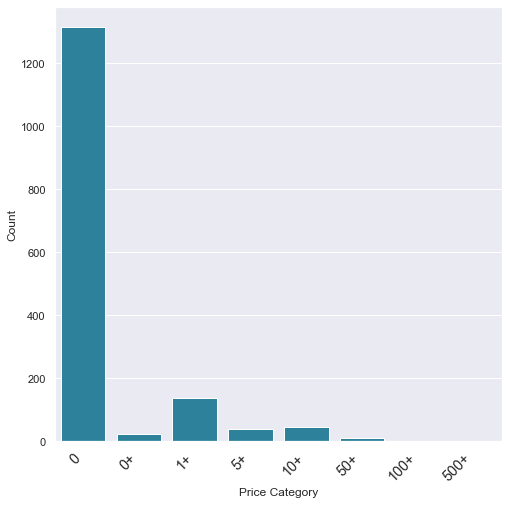

In [21]:
draw_count_plot(df, 'Price Category', 'Price Category', 'Count', fig_size=(8,8), 
               order=price_range_order)

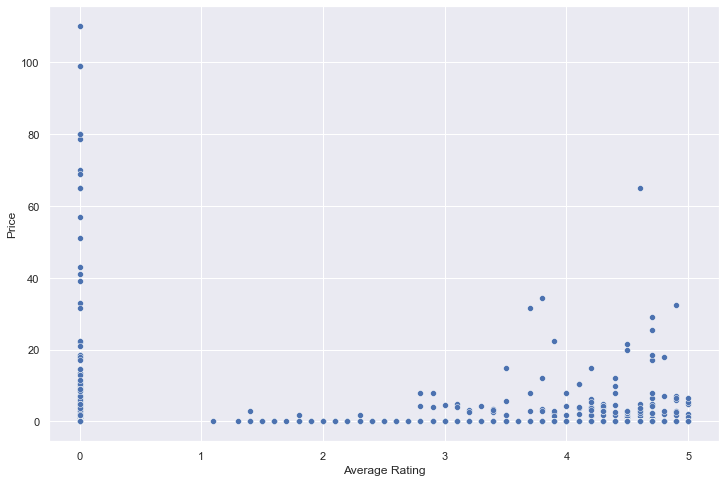

In [22]:
sbn.scatterplot(data=df, y='Price', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

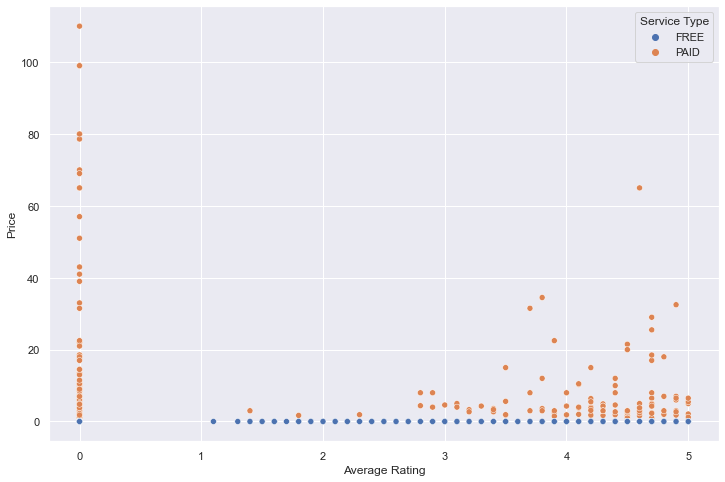

In [23]:
sbn.scatterplot(data=df, y='Price', x='Average Rating', hue='Service Type', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

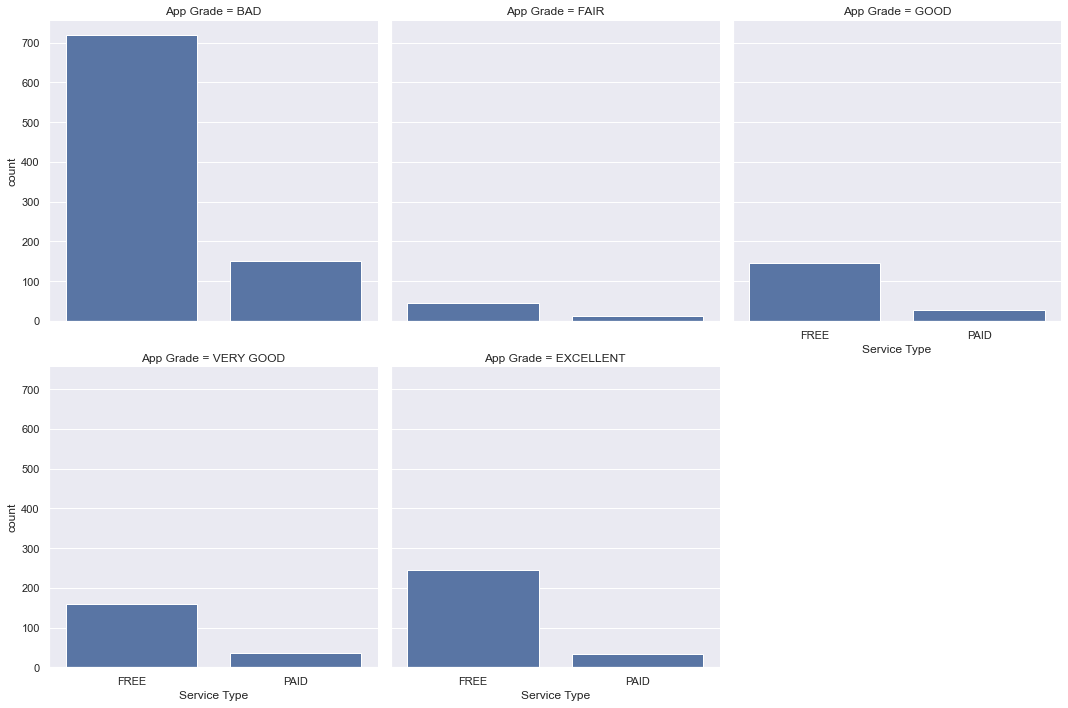

In [24]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Service Type", order=['FREE', 'PAID'])

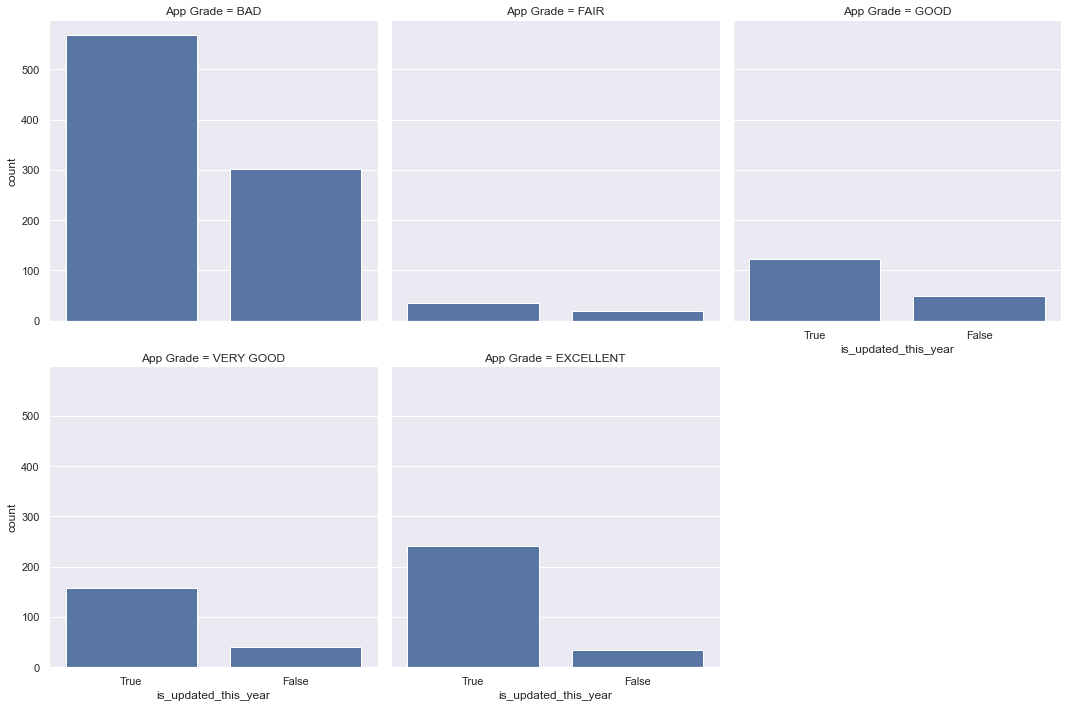

In [25]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "is_updated_this_year", order=[True, False])

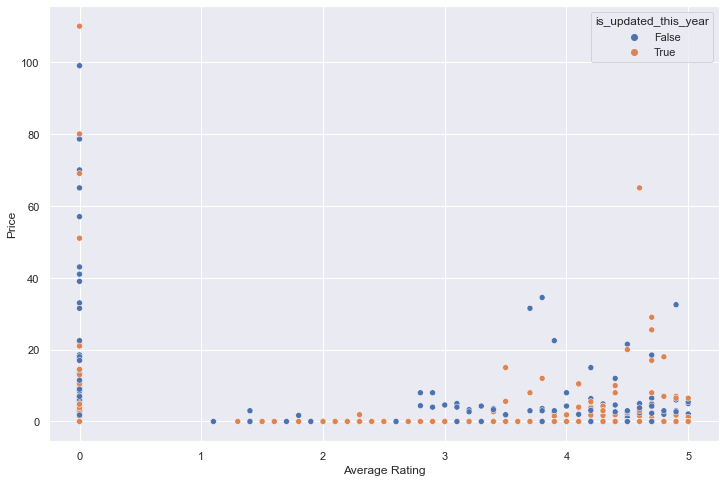

In [26]:
sbn.scatterplot(data=df, x='Average Rating', y='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


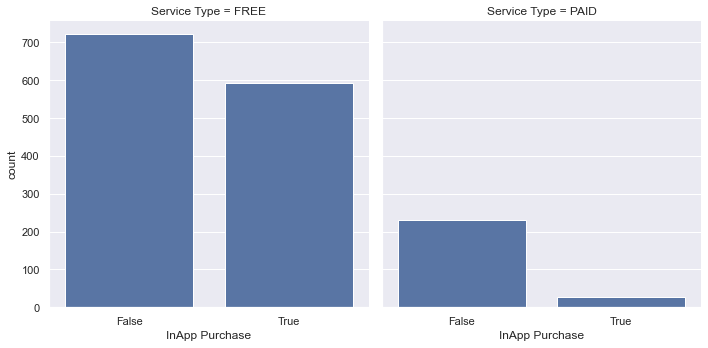

In [27]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Service Type", col_wrap=2, height=5, aspect=1.0)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase")

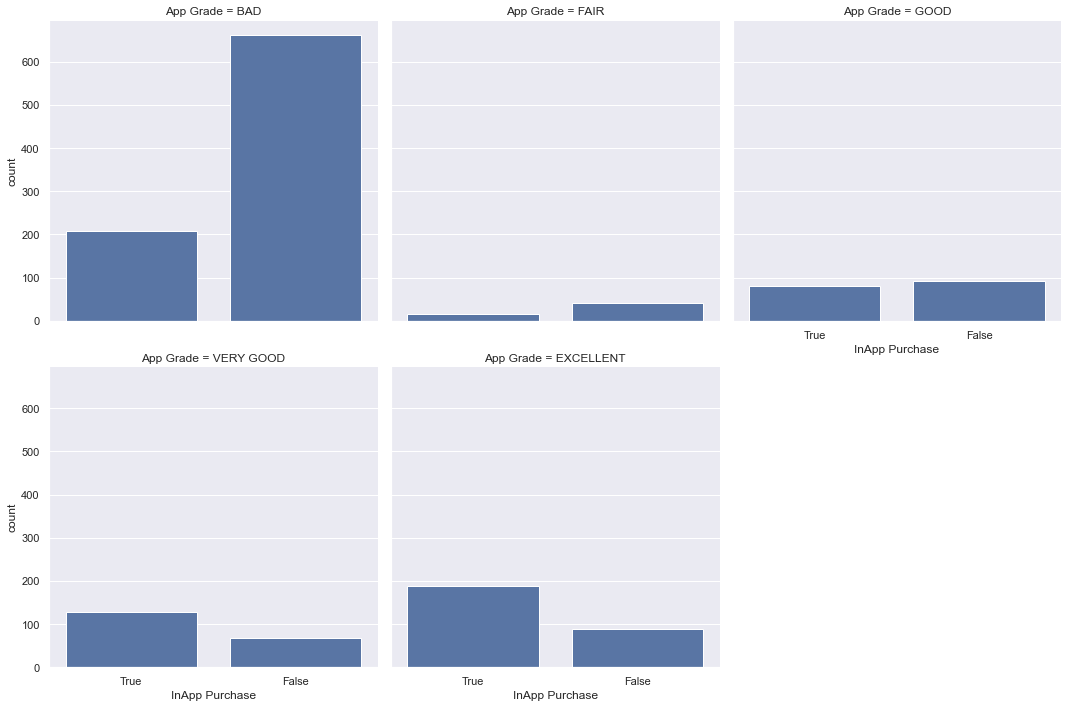

In [28]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase", order=[True, False])

#### Application Rating effect on the app?

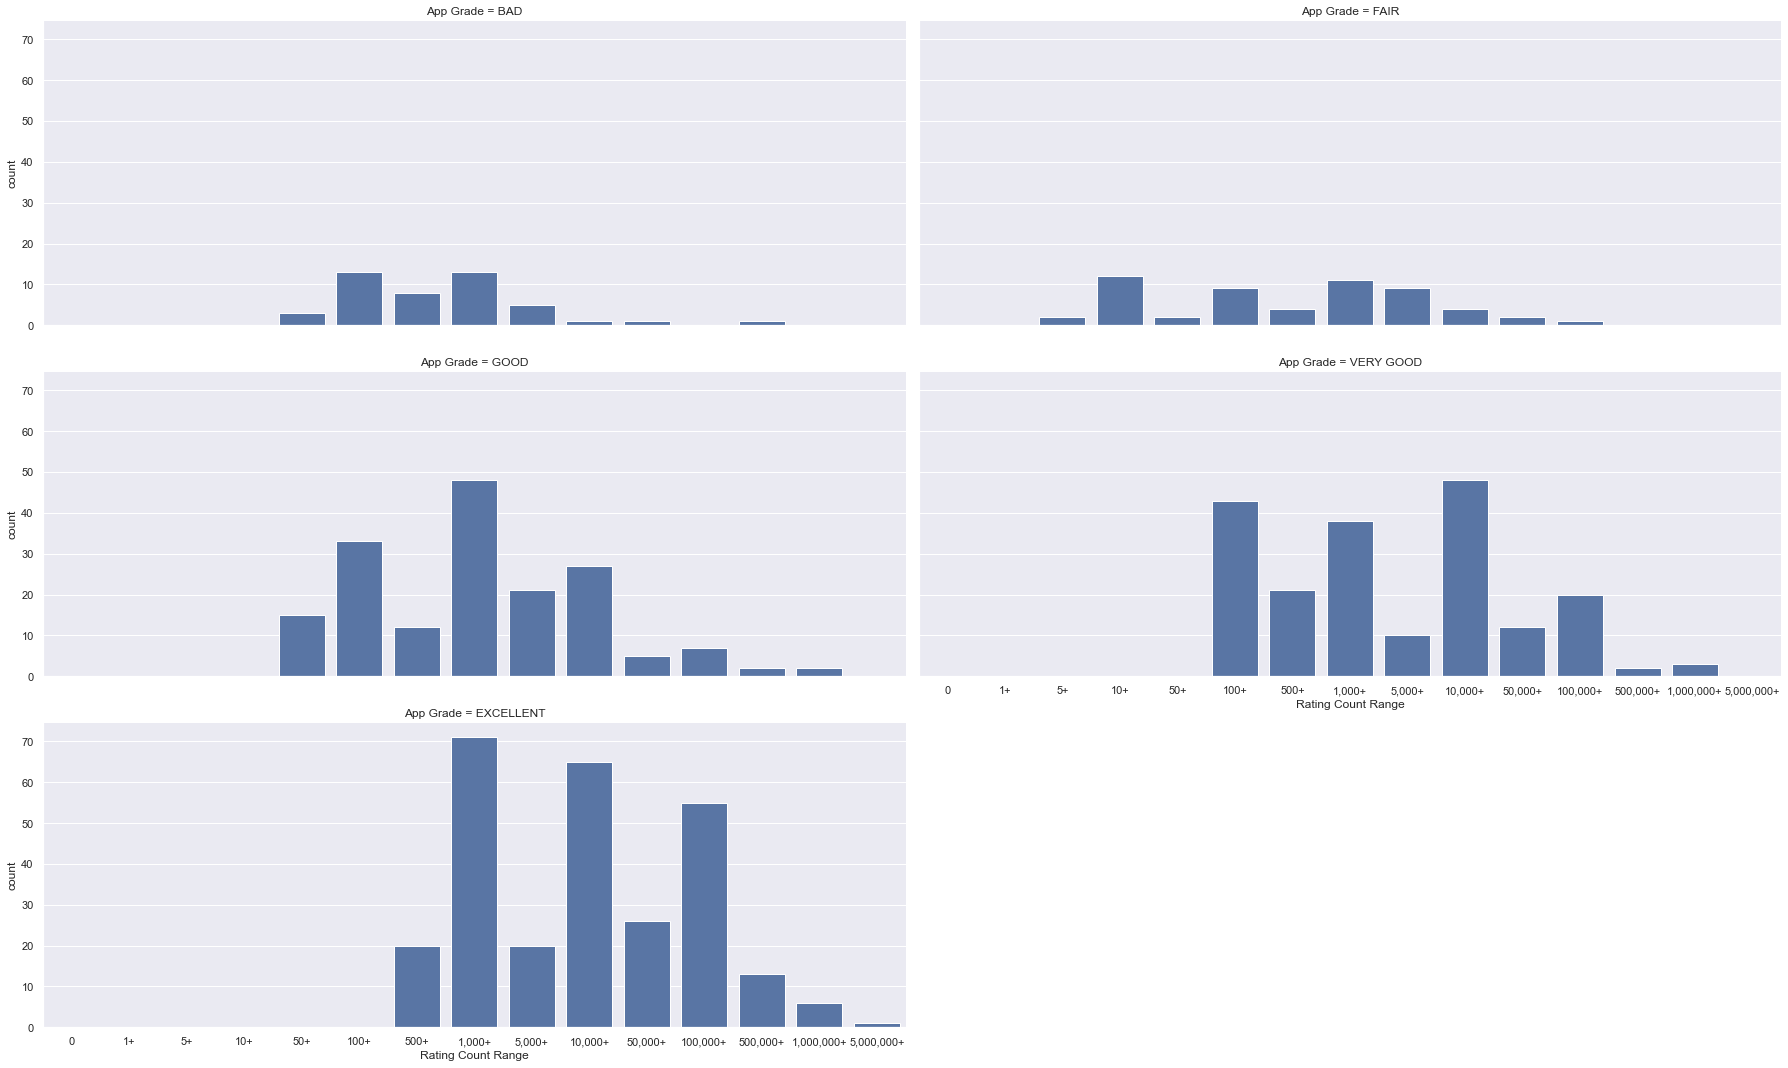

In [29]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=2.5,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

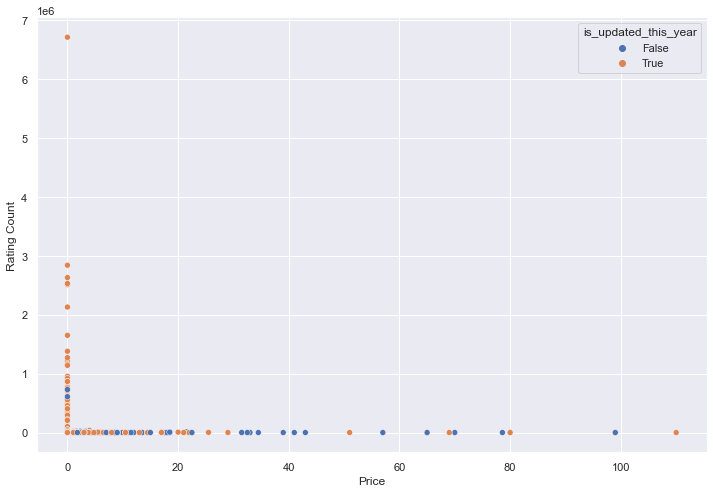

In [30]:
sbn.scatterplot(data=df, y='Rating Count', x='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

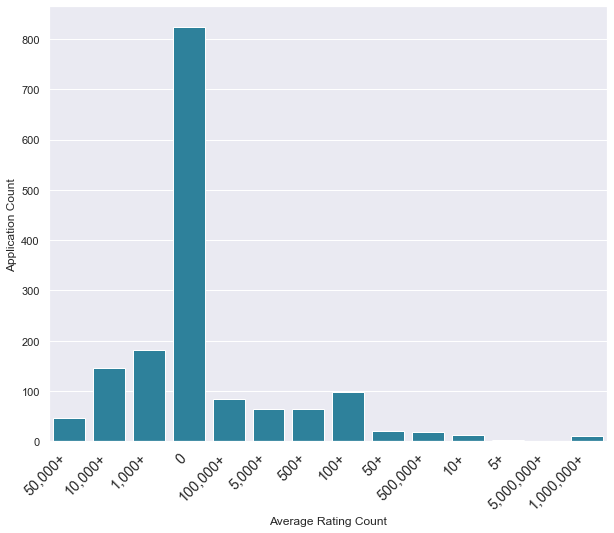

In [31]:
draw_count_plot(df, 'Rating Count Range', 'Average Rating Count', 'Application Count', fig_size=(10,8))

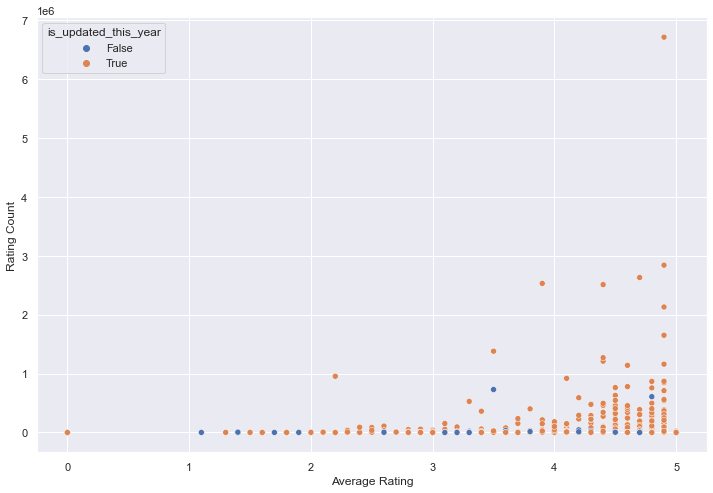

In [32]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

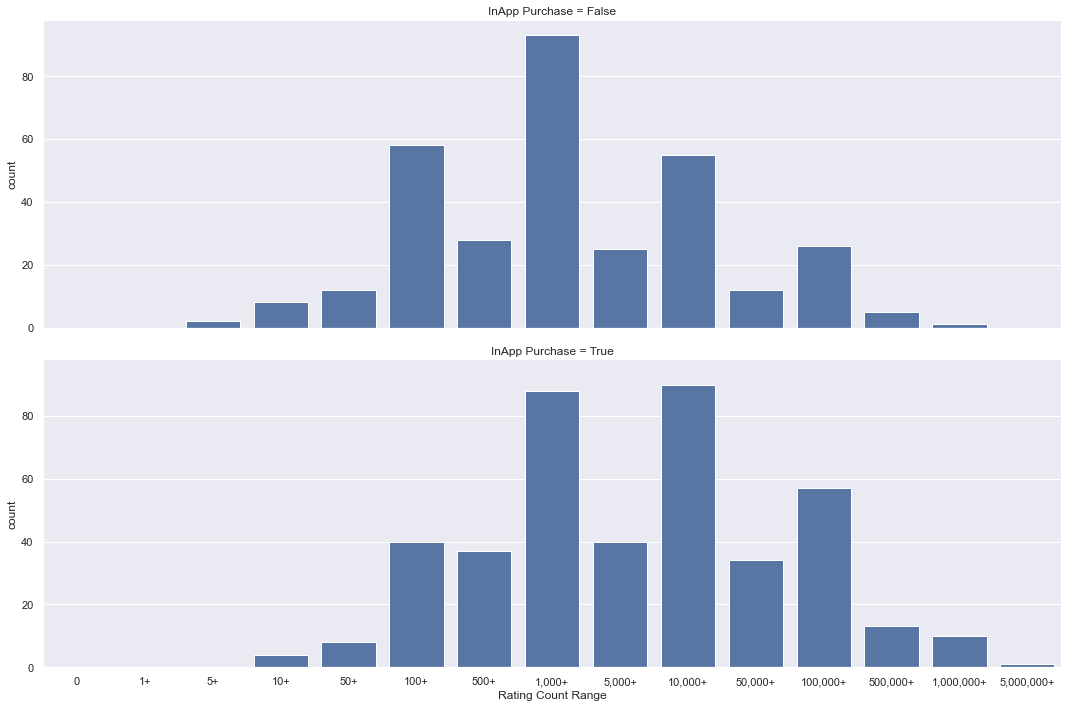

In [33]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="InApp Purchase", col_wrap=1, height=5, aspect=3.0)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

#### Application Type 

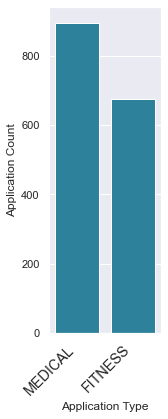

In [34]:
draw_count_plot(df, 'Application Type', 'Application Type', 'Application Count', fig_size=(2,6))

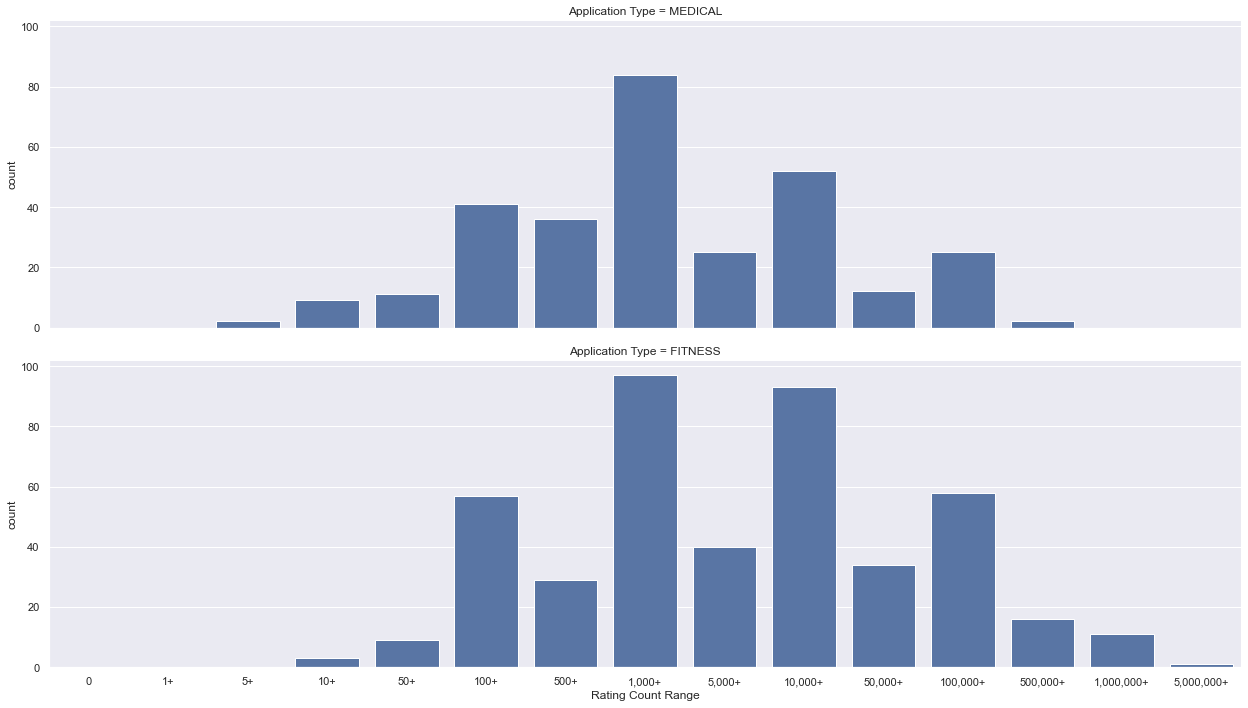

In [35]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Application Type", col_wrap=1, height=5, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

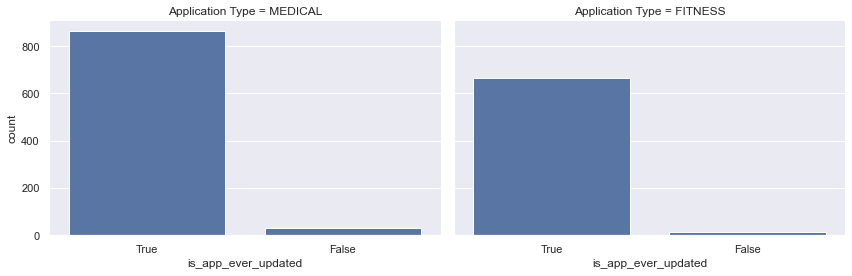

In [36]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Application Type", col_wrap=2, height=4, aspect=1.5)
eng_supp_app_grade_plot.map(sbn.countplot, "is_app_ever_updated", order=[True, False])

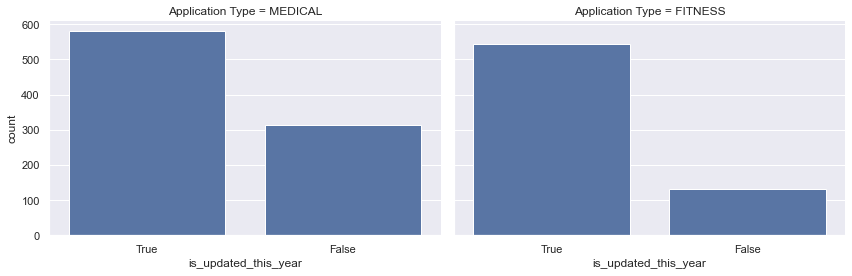

In [37]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Application Type", col_wrap=2, height=4, aspect=1.5)
eng_supp_app_grade_plot.map(sbn.countplot, "is_updated_this_year", order=[True, False])

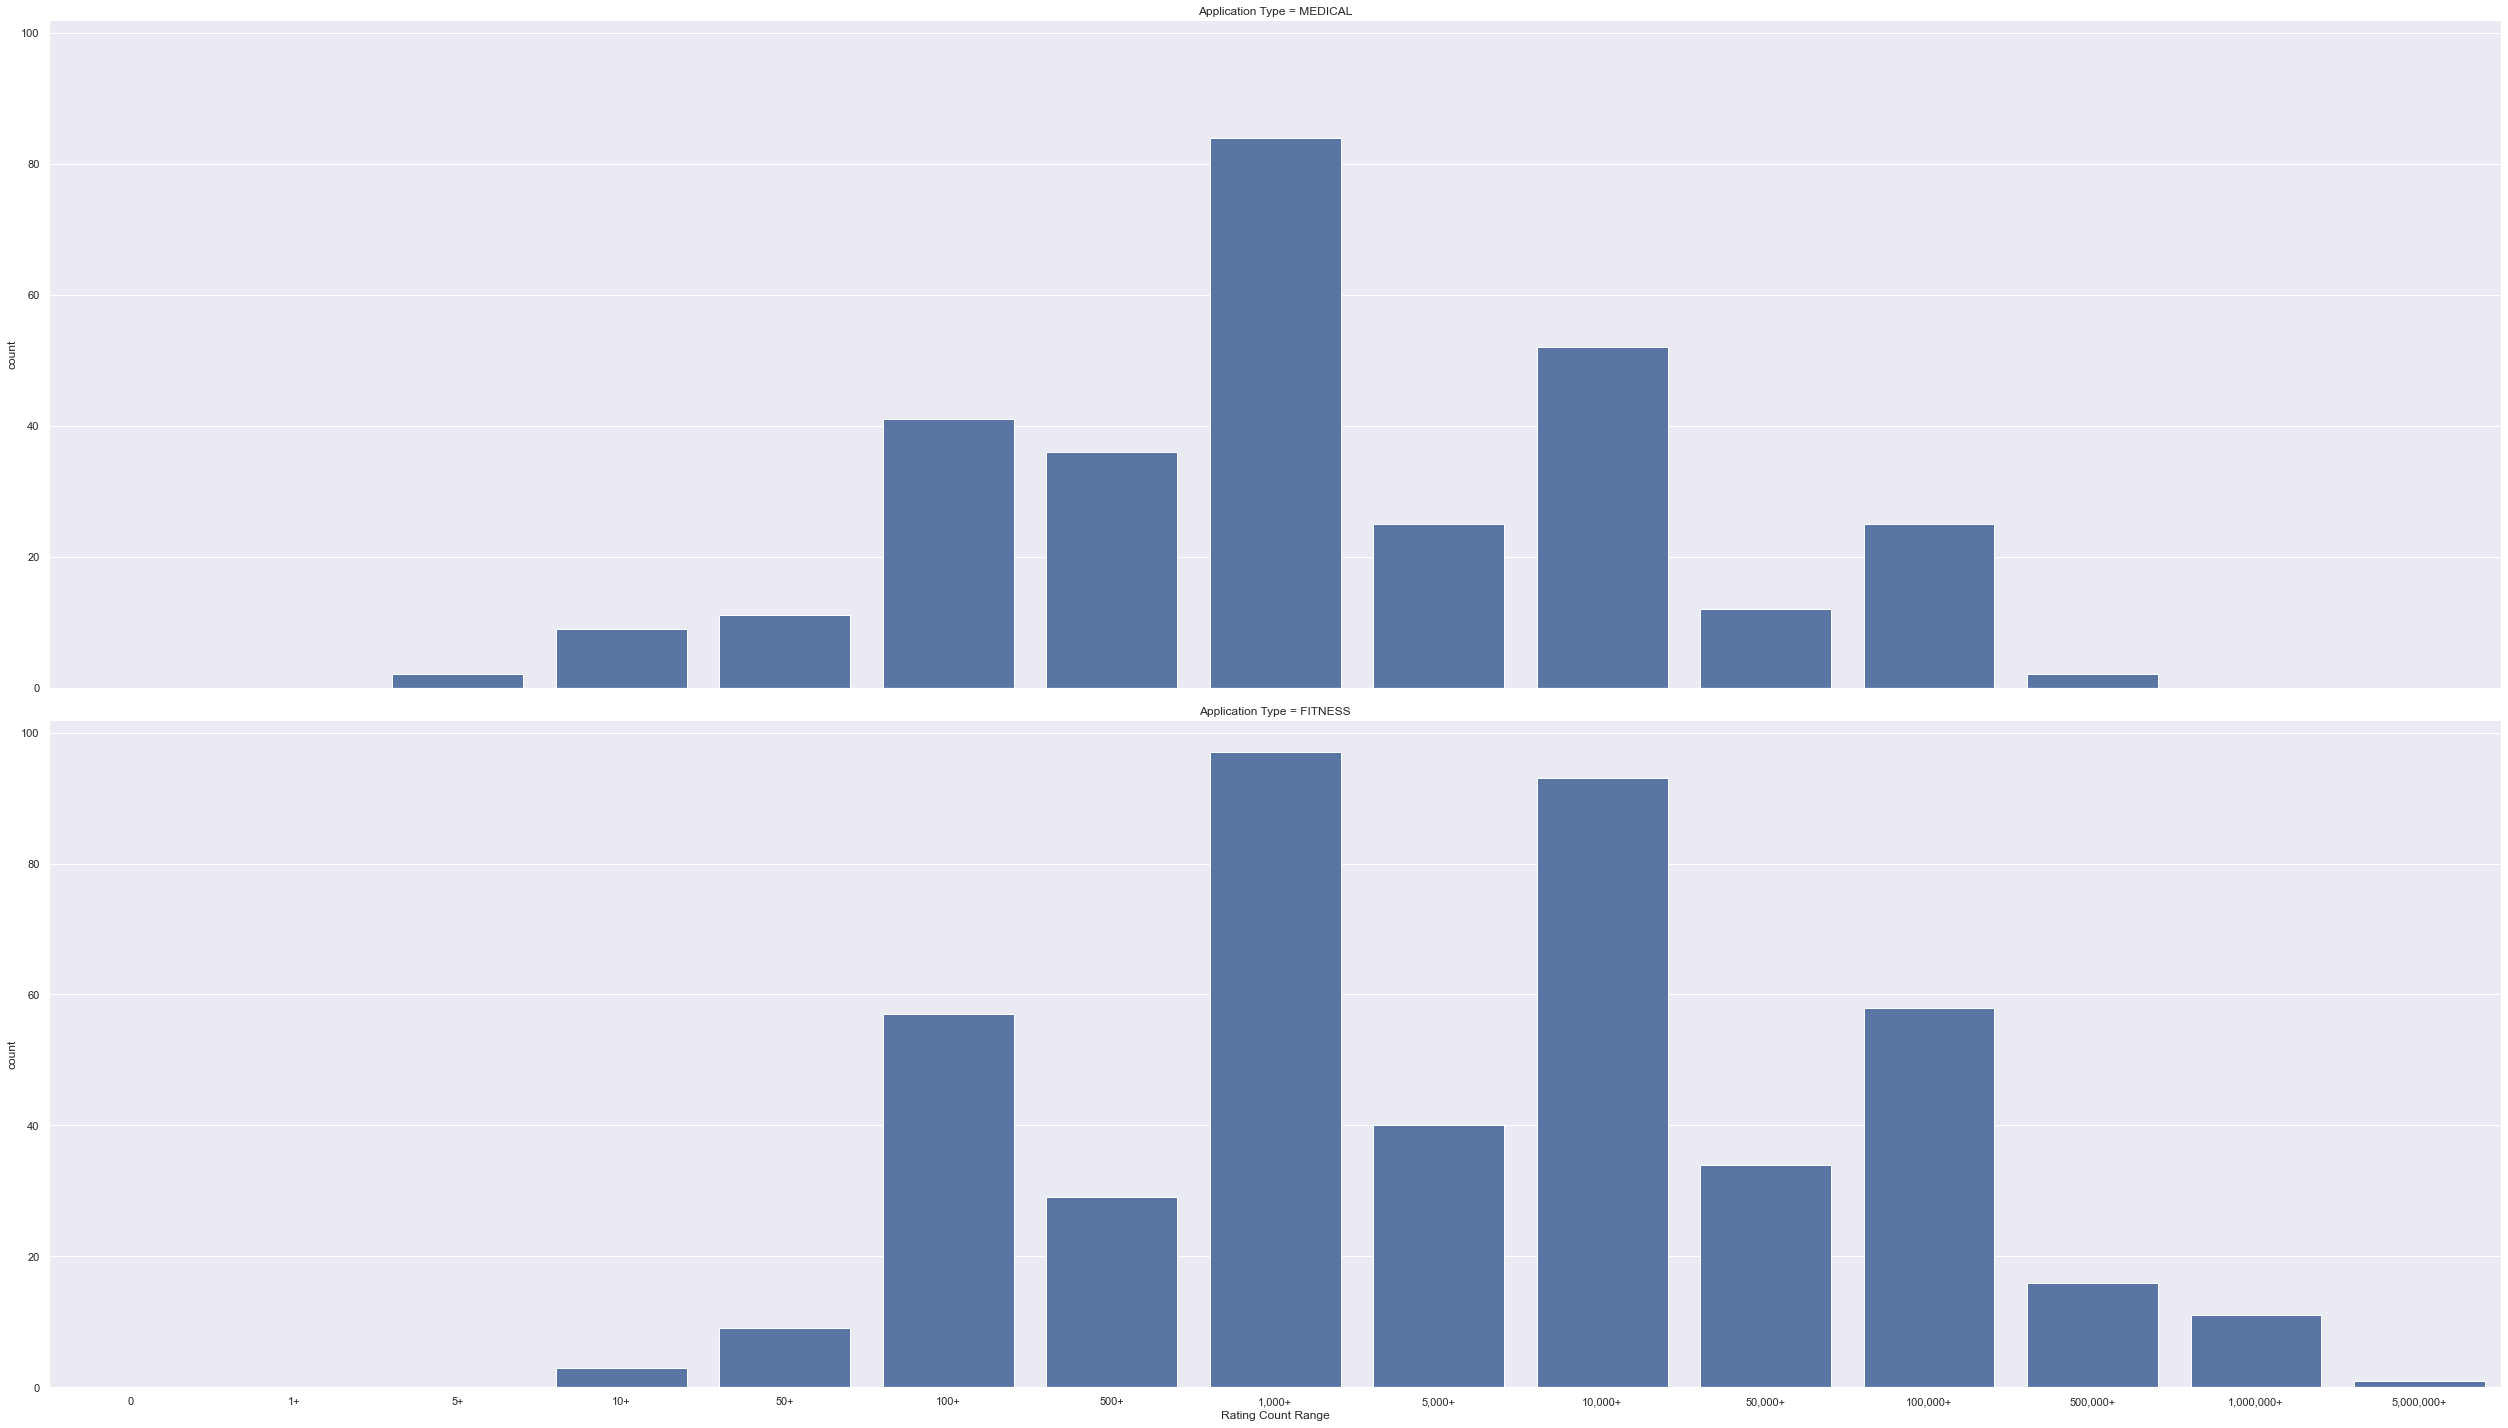

In [38]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Application Type" ,col_wrap=1, 
                                        height=10, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

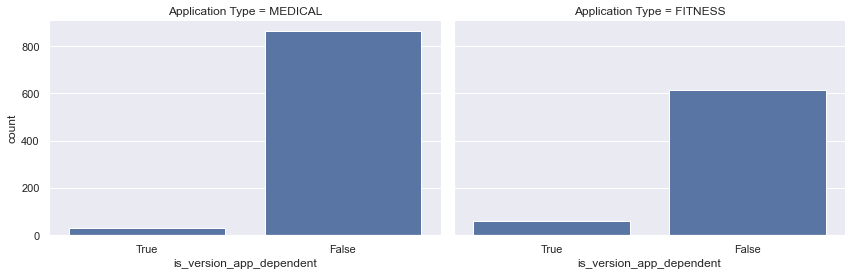

In [39]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Application Type", col_wrap=2, height=4, aspect=1.5)
eng_supp_app_grade_plot.map(sbn.countplot, "is_version_app_dependent", order=[True, False])

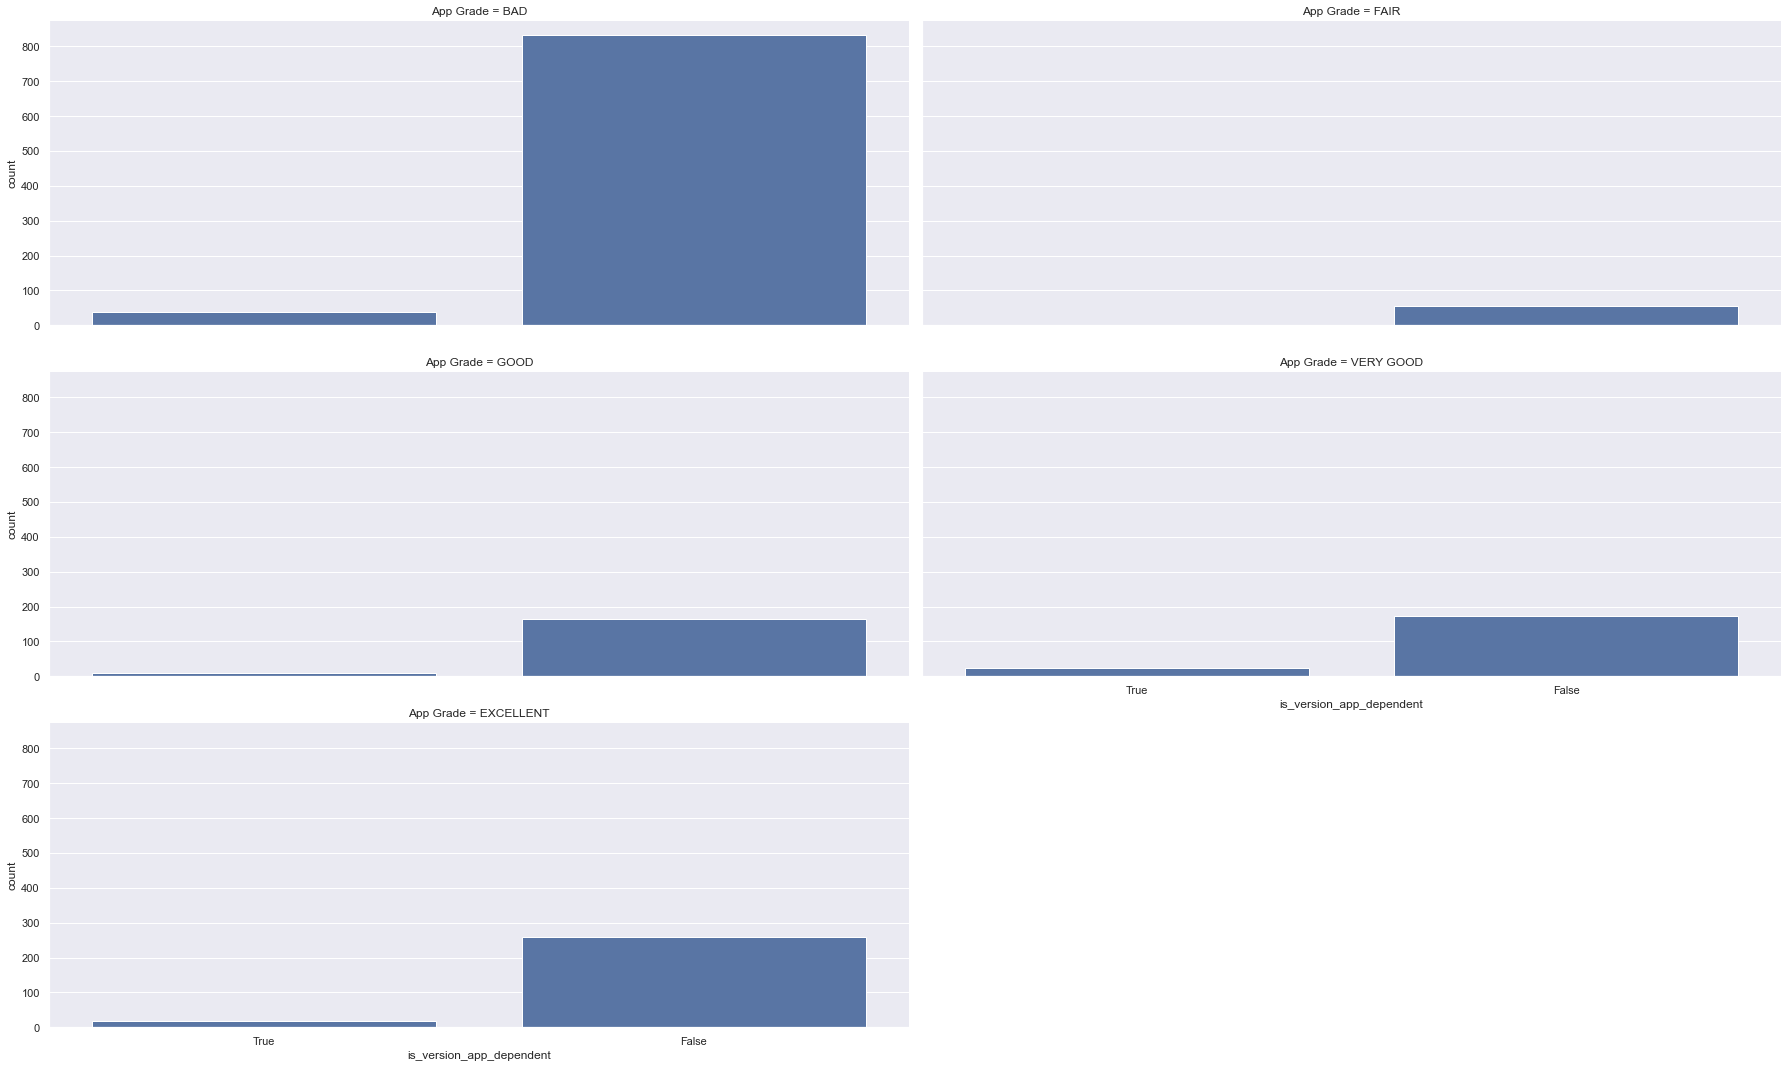

In [40]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=2.5,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "is_version_app_dependent", order=[True, False])

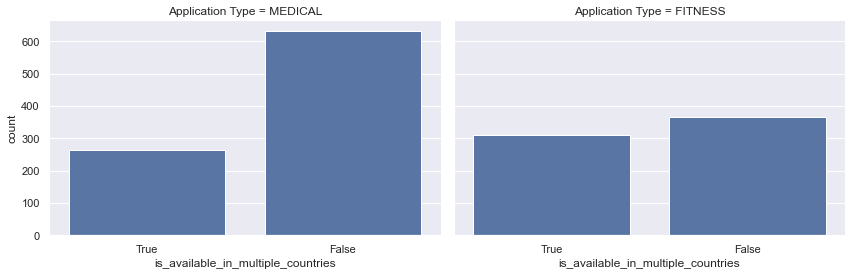

In [41]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Application Type", col_wrap=2, height=4, aspect=1.5)
eng_supp_app_grade_plot.map(sbn.countplot, "is_available_in_multiple_countries", order=[True, False])

#### ASSOCIATION RULE MINING

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1571 non-null   int64  
 1   App Name                            1571 non-null   object 
 2   Age Rating                          1571 non-null   object 
 3   Price                               1571 non-null   float64
 4   InApp Purchase                      1571 non-null   bool   
 5   Average Rating                      1571 non-null   float64
 6   Rating Count                        1571 non-null   int64  
 7   App Link                            1571 non-null   object 
 8   Last Updated                        1571 non-null   object 
 9   Released Date                       1317 non-null   object 
 10  Downloads                           1571 non-null   object 
 11  Version                             1570 no

In [43]:
def convert_consequent_to_str(consq):
    return str(consq).replace("frozenset({'", '').replace("})", '').replace("'", '')

def convert_antecedent_to_str(antecedent):
    antecedent = str(antecedent).replace("frozenset({'", '').replace("})", '').replace("'", '')
    return antecedent

def prepare_apriori_columns(df, column_list):
    apriori_df = list()
    for col in column_list:
        apriori_df.append(pd.get_dummies(df[col], prefix=col))
    apriori_df = pd.concat(apriori_df, axis=1)
    return apriori_df

def get_conditions_which_apps_are_most_likely_rated(min_support, min_threshold):
    apriori_df = prepare_apriori_columns(df,['Age Rating', 'InApp Purchase', 'Downloads',
                                                       'App Grade', 'is_app_ever_updated', 
                        'Service Type', 'is_available_in_multiple_countries', 'Rating Count Range',
                                             'is_updated_this_year', 'Price Category'] )
    rules = apriori(apriori_df, min_support=min_support, use_colnames=True)
    association_rules_df = association_rules(rules, metric='confidence', min_threshold=min_threshold)
    association_rules_df["antecedent_len"] = association_rules_df["antecedents"].apply(lambda x: len(x))
    association_rules_df["consequents_len"] = association_rules_df["consequents"].apply(lambda x: len(x))
    association_rules_df['antecedents'] = association_rules_df['antecedents'].apply(convert_antecedent_to_str)
    association_rules_df['consequents'] = association_rules_df['consequents'].apply(convert_consequent_to_str)
    association_rules_df.sort_values(by=['confidence'], ascending=False, inplace=True)
    return association_rules_df[(association_rules_df['consequents_len']==1) & 
                                (association_rules_df['antecedent_len']>1)]

In [44]:
def print_consequents_and_antecedents(df, consequent):
    filtered_df = df[df['consequents'].str.find(consequent) > -1]
    i = 1
    for index in filtered_df.index:
        if (i < 10):
            ants = filtered_df.at[index, 'antecedents']
            cons = filtered_df.at[index, 'consequents']
            support = filtered_df.at[index, 'support']
            conviction = filtered_df.at[index, 'conviction']
            confidence = filtered_df.at[index, 'confidence']
            print(f'{i}. {ants} => {cons} ({round(support,2), round(confidence,2), round(conviction,2)})')
            i = i + 1

In [45]:
association_df = get_conditions_which_apps_are_most_likely_rated(0.5, 0.5)

In [46]:
print_consequents_and_antecedents(association_df,'Service Type')

1. is_app_ever_updated_True, Price Category_0, is_updated_this_year_True => Service Type_FREE ((0.65, 1.0, inf))
2. Age Rating_PEGI 3, Price Category_0, is_available_in_multiple_countries_False, is_app_ever_updated_True => Service Type_FREE ((0.55, 1.0, inf))
3. Price Category_0, is_available_in_multiple_countries_False, is_app_ever_updated_True => Service Type_FREE ((0.56, 1.0, inf))
4. Age Rating_PEGI 3, is_updated_this_year_True, Price Category_0, is_app_ever_updated_True => Service Type_FREE ((0.63, 1.0, inf))
5. Price Category_0, Age Rating_PEGI 3, is_available_in_multiple_countries_False => Service Type_FREE ((0.56, 1.0, inf))
6. Price Category_0, is_available_in_multiple_countries_False => Service Type_FREE ((0.57, 1.0, inf))
7. Price Category_0, is_updated_this_year_True => Service Type_FREE ((0.65, 1.0, inf))
8. Price Category_0, Age Rating_PEGI 3, is_app_ever_updated_True => Service Type_FREE ((0.79, 1.0, inf))
9. Price Category_0, is_app_ever_updated_True => Service Type_FRE

In [47]:
print_consequents_and_antecedents(association_df,'App Grade')

1. Age Rating_PEGI 3, Rating Count Range_0 => App Grade_BAD ((0.51, 1.0, inf))
2. Age Rating_PEGI 3, is_app_ever_updated_True => App Grade_BAD ((0.52, 0.55, 0.99))


In [48]:
print_consequents_and_antecedents(association_df,'Age Rating')

1. App Grade_BAD, Rating Count Range_0 => Age Rating_PEGI 3 ((0.51, 0.98, 1.82))
2. is_app_ever_updated_True, App Grade_BAD => Age Rating_PEGI 3 ((0.52, 0.98, 1.71))
3. InApp Purchase_False, is_app_ever_updated_True => Age Rating_PEGI 3 ((0.57, 0.98, 1.68))
4. is_available_in_multiple_countries_False, is_app_ever_updated_True => Age Rating_PEGI 3 ((0.6, 0.97, 1.24))
5. Service Type_FREE, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.56, 0.97, 1.2))
6. Price Category_0, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.56, 0.97, 1.2))
7. Price Category_0, Service Type_FREE, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.56, 0.97, 1.2))
8. Price Category_0, is_available_in_multiple_countries_False, is_app_ever_updated_True => Age Rating_PEGI 3 ((0.55, 0.97, 1.17))
9. Service Type_FREE, is_available_in_multiple_countries_False, is_app_ever_updated_True => Age Rating_PEGI 3 ((0.55, 0.97, 1.17))


In [49]:
print_consequents_and_antecedents(association_df,'is_updated_this_year')

1. Age Rating_PEGI 3, Price Category_0, is_app_ever_updated_True => is_updated_this_year_True ((0.63, 0.79, 1.37))
2. Price Category_0, Service Type_FREE, Age Rating_PEGI 3, is_app_ever_updated_True => is_updated_this_year_True ((0.63, 0.79, 1.37))
3. Age Rating_PEGI 3, Service Type_FREE, is_app_ever_updated_True => is_updated_this_year_True ((0.63, 0.79, 1.37))
4. Service Type_FREE, is_app_ever_updated_True => is_updated_this_year_True ((0.65, 0.79, 1.34))
5. Price Category_0, is_app_ever_updated_True => is_updated_this_year_True ((0.65, 0.79, 1.34))
6. Price Category_0, Service Type_FREE, is_app_ever_updated_True => is_updated_this_year_True ((0.65, 0.79, 1.34))
7. Price Category_0, Age Rating_PEGI 3, Service Type_FREE => is_updated_this_year_True ((0.63, 0.78, 1.27))
8. Age Rating_PEGI 3, Service Type_FREE => is_updated_this_year_True ((0.63, 0.78, 1.27))
9. Age Rating_PEGI 3, Price Category_0 => is_updated_this_year_True ((0.63, 0.78, 1.27))


In [50]:
print_consequents_and_antecedents(association_df,'Price Category')

1. Age Rating_PEGI 3, Service Type_FREE, is_app_ever_updated_True => Price Category_0 ((0.79, 1.0, inf))
2. Age Rating_PEGI 3, Service Type_FREE, is_available_in_multiple_countries_False, is_app_ever_updated_True => Price Category_0 ((0.55, 1.0, inf))
3. Service Type_FREE, is_available_in_multiple_countries_False, is_app_ever_updated_True => Price Category_0 ((0.56, 1.0, inf))
4. Age Rating_PEGI 3, is_updated_this_year_True, Service Type_FREE, is_app_ever_updated_True => Price Category_0 ((0.63, 1.0, inf))
5. is_available_in_multiple_countries_False, Age Rating_PEGI 3, Service Type_FREE => Price Category_0 ((0.56, 1.0, inf))
6. Service Type_FREE, is_available_in_multiple_countries_False => Price Category_0 ((0.57, 1.0, inf))
7. Service Type_FREE, is_updated_this_year_True => Price Category_0 ((0.65, 1.0, inf))
8. Age Rating_PEGI 3, Service Type_FREE, is_updated_this_year_True => Price Category_0 ((0.63, 1.0, inf))
9. Age Rating_PEGI 3, Service Type_FREE => Price Category_0 ((0.81, 1.0,

#### CLUSTERING

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1571 non-null   int64  
 1   App Name                            1571 non-null   object 
 2   Age Rating                          1571 non-null   object 
 3   Price                               1571 non-null   float64
 4   InApp Purchase                      1571 non-null   bool   
 5   Average Rating                      1571 non-null   float64
 6   Rating Count                        1571 non-null   int64  
 7   App Link                            1571 non-null   object 
 8   Last Updated                        1571 non-null   object 
 9   Released Date                       1317 non-null   object 
 10  Downloads                           1571 non-null   object 
 11  Version                             1570 no

- Rating Count
- Country Count
- Price
- Average Rating

In [52]:
def draw_elbow_graph(kmeans_df):
    wcss=[]
    for i in range(1,15):
        kmeans = KMeans(i)
        kmeans.fit(kmeans_df)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,15)
    pyplot.subplot(2, 2, 1)
    pyplot.plot(number_clusters,wcss)
    pyplot.title('The Elbow title')
    pyplot.xlabel('Number of clusters')
    pyplot.ylabel('WCSS')
    fig = pyplot.gcf()
    fig.set_size_inches(24, 16)

In [53]:
def execute_kmeans(df, columns,n_cluster):
    standard_scaler = StandardScaler()
    kmeans_df = df[columns]
    kmeans_df_scaled = standard_scaler.fit_transform(kmeans_df)
    draw_elbow_graph(kmeans_df_scaled)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(kmeans_df_scaled)
    labels = kmeans.predict(kmeans_df_scaled)
    centroids = kmeans.cluster_centers_
    kmeans_df_cluster = kmeans_df.copy()
    kmeans_df_cluster['cluster'] = labels
#     print(kmeans_df_cluster['cluster'].value_counts())
    if (len(columns) == 3):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    elif (len(columns) == 4):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] , kmeans_df_scaled[:,3]
                   ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], kmeans.cluster_centers_[:,3], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    else:
        ax = pyplot.subplot(2, 2, 2)
        ax.scatter(kmeans_df_scaled[:, 0],kmeans_df_scaled[:, 1],
            c=kmeans.labels_, cmap='rainbow')
    
    fig = pyplot.gcf()
    fig.set_size_inches(20, 16)
    return kmeans_df_cluster

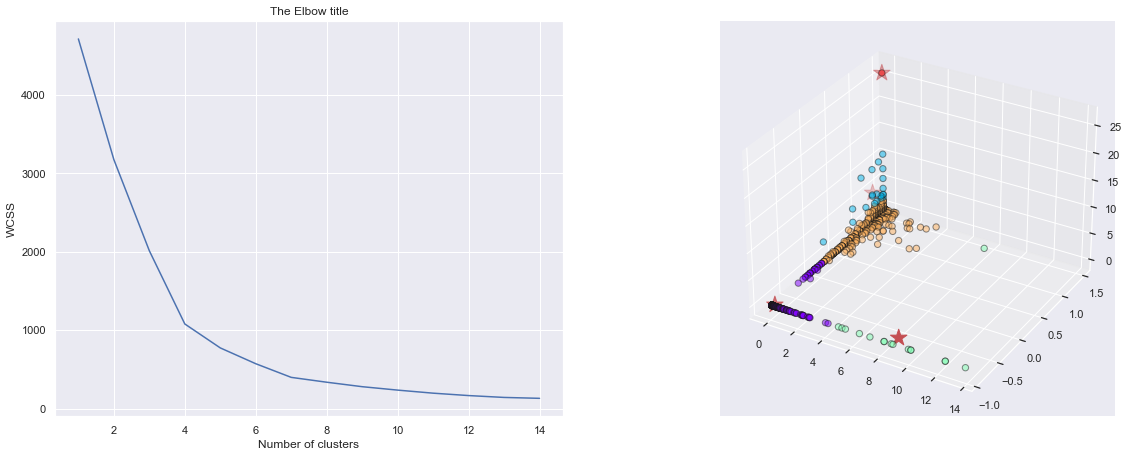

In [54]:
kmeans_df_cluster_df1 = execute_kmeans(df, ['Price', 'Average Rating', 'Rating Count'], 5)

In [55]:
kmeans_df_cluster_df1['cluster'].value_counts()

0    838
3    695
1     21
2     16
4      1
Name: cluster, dtype: int64

In [56]:
kmeans_df_cluster_df1.groupby(by='cluster').min()

,Price,Average Rating,Rating Count
cluster,,,
0,0.00,0.0,0
1,0.00,2.2,710000
2,38.99,0.0,0
3,0.00,2.2,5
4,0.00,4.9,6710000


In [57]:
kmeans_df_cluster_df1.groupby(by='cluster').max()

,Price,Average Rating,Rating Count
cluster,,,
0,32.99,2.1,7940
1,0.00,4.9,2840000
2,109.99,4.6,76
3,34.49,5.0,630000
4,0.00,4.9,6710000


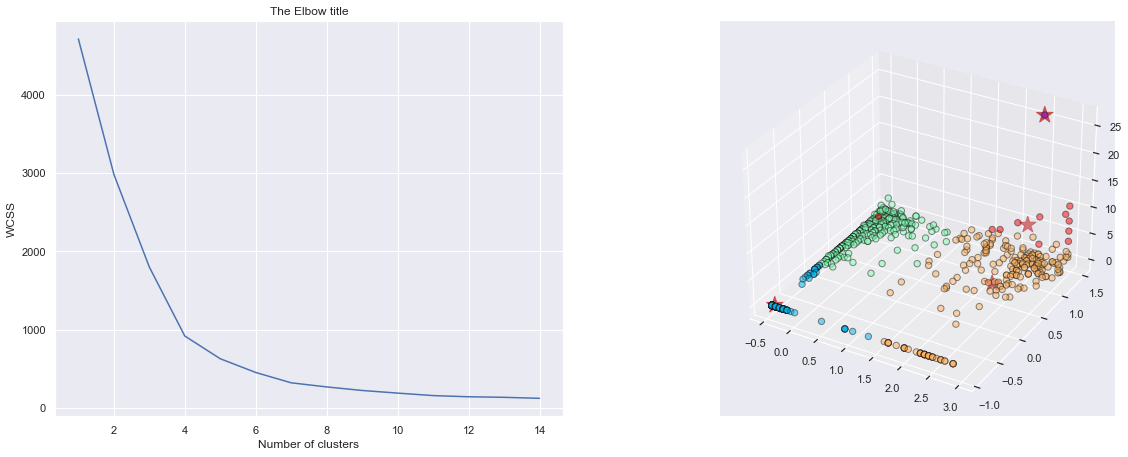

In [58]:
kmeans_df_cluster_df2 = execute_kmeans(df, ['Country Count', 'Average Rating', 'Rating Count'], 5)

In [59]:
kmeans_df_cluster_df2['cluster'].value_counts()

1    795
2    530
3    234
4     11
0      1
Name: cluster, dtype: int64

In [60]:
kmeans_df_cluster_df2.groupby(by='cluster').min()

,Country Count,Average Rating,Rating Count
cluster,,,
0,43,4.9,6710000
1,1,0.0,0
2,1,2.1,5
3,21,0.0,0
4,8,3.5,1140000


In [61]:
kmeans_df_cluster_df2.groupby(by='cluster').max()

,Country Count,Average Rating,Rating Count
cluster,,,
0,43,4.9,6710000
1,26,2.0,7940
2,21,5.0,867000
3,50,5.0,954000
4,50,4.9,2840000
